In [1]:
import numpy as np
import pyvista as pv

import structgeo.model as geo
import structgeo.plot as geovis

# Static plots:
pv.set_jupyter_backend('static')
# Dynamic plots:
# pv.set_jupyter_backend('trame')
# pv.set_jupyter_backend('html')


## GeoModel
The GeoModel class provides the framework to construct 3D geological models from a defined sequence of GeoProcesses.

- **Flexible Grid Definition**: Define your grid by specifying bounds. Provide a single min/max tuple for a cubic grid or distinct min/max tuples for each axis to create a rectangular prism.
- **Adjustable Resolution**: Control the granularity of the grid with the resolution parameter, which sets the number of divisions along each axis. Each axis can have a different resloution.
- **Data Type**: Optimize memory usage and computation speed by specifying the data type of the grid values, with np.float32 as the default

In [2]:
# Cubic model
bounds = (-10, 10)
resolution = 128
model = geo.GeoModel(bounds=bounds, resolution=resolution)

# Alternatively, you can specify different bounds and resolution for each axis
bounds = ((-20, 20), (-20, 20), (-10, 10))
resolution = (128, 128, 64)
model = geo.GeoModel(bounds=bounds, resolution=resolution)

## GeoProcess

GeoProcess is a base class for modeling geological events in the GeoModel framework. There are two types of geological modifications: Depositions and Transformations. The Transformations are operations that modify the mesh geometry and can be reversed in time. The Depositions are operations that add or remove geological materials without changing the arrangement of the mesh points.

The reasoning for this division is explained further below.

There are two types of geological modifications: Depositions and Transformations

#### Depositions:
These processes add or remove geological materials (e.g., rock layers, dikes) to the model without changing the spatial coordinates of the mesh.

Examples:

**Layer**: Adds horizontal layers of material, defined by a base, width, and material value.

**Dike**: Inserts a vertical or angled planar feature defined by strike, dip, and width.

**Sedimentation**: Simulates the accumulation of sediment layers, where each layer's thickness can be randomly determined.

#### Transformations:
These processes alter the geometry of the mesh (the spatial coordinates) to simulate geological forces, without changing the properties assigned to the mesh points.

Examples:

**Fold**: Deforms the mesh to create a fold structure, defined by a wavelength, amplitude, and orientation.

**Fault**: Displaces the mesh along a planar surface, defined by strike, dip, and offset.

#### Frame Convention: 

**North** corresponds to the positive Y-axis.

Transformations consider this orientation when applying modifications like strike and dip. Strike is measured from the north in a clockwise direction, and dip is the angle from the horizontal plane. PyVista which is used for visualization can show the x,y,z axes in reference to the model. This is done in the code by adding the axes actor to the plotter.

#### Building Geological History:
A list of GeoProcesses can be added to a GeoModel to build up a history of events. Once a full history is defined, the model can be computed to visualize the cumulative effects of the geological processes.

History Management: Add one or more events to the history using the add history method. The order of the events in the history list determines the sequence in which they are applied to the model. To clear the history use the clear history method. This will remove all events from the history list but not change the model data until it is recomputed.

#### Model Computation
<img src="https://i.imgur.com/sPS9JmN.png" width="1200" >

The model has the restriction that we are on a meshgrid in the present where all the points are evenly spaced. However any Transformation process will alter the grid, making the points unevenly spaced. In order to correctly apply Deposition events, we need to know the mesh points in the past, which is done be reversing the history of Transformations. Intermediate states are cached along the way as snapshots in the time reversal process. The Transformations implicitly do not rely on the past state of the model, only the current state. This is why they can be reversed in time.

The Deposition events rely on the past state of the model. For example a Dike is deposited only where there is already existing material, which can not be known without having information about the past. For this reason these events are processed as part of the forward time computation, using the cached snapshots of the model at each step.

In [3]:
# Bedrock forms the basement layer of the model.  
bedrock = geo.Bedrock(base=-5, value=1)

# Sedimentation is a layer a stack of layers that are deposited starting from either the
# lowest empty space in the mesh or from a specified base.

# We specify a list of values for the sediment layers and a list of thicknesses. If too few thicknesses
# are specified, the thickness list cycles again

sediment0 = geo.Sedimentation(value_list=[2, 3, 4,5], thickness_list=[1, 2])

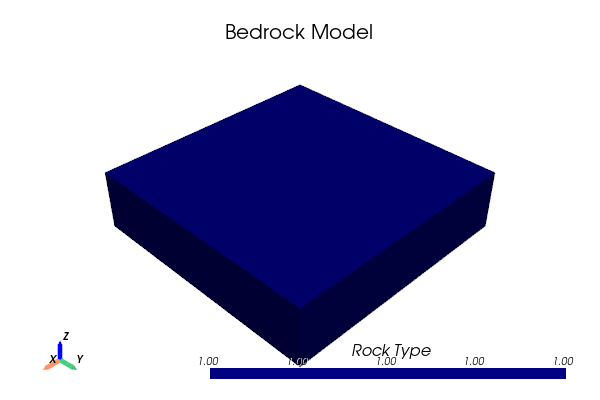

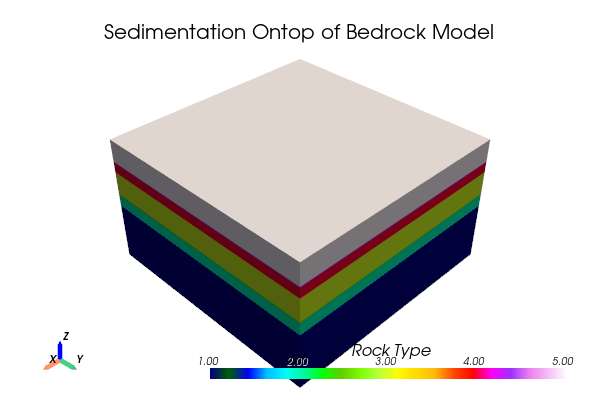

In [4]:
model = geo.GeoModel(bounds=(-10,10), resolution=128)
model.clear_history()
# Add a base layer of bedrock
model.add_history(bedrock)
model.compute_model()
p = geovis.volview(model)
window_size = (600, 400)
p.window_size = window_size
p.add_title(title='Bedrock Model', font_size=8)
p.show()

model.add_history(sediment0)
model.compute_model()
p2 = geovis.volview(model)
p2.window_size = window_size
p2.add_title(title='Sedimentation Ontop of Bedrock Model', font_size=8)
p2.show()


### Sedimentation
The basic sedimentation process builds layers up vertically from either a specified base or the lowest non-rock value in the model. 

The number of layers is determines by the number of values passed in the values_list.
The thickness of each layer is controlled by the corresponding thickness_list, however if fewer thicknesses than values are passed, the thickness list will repeat.

Example:
Pass values `[1,2,3]` and thicknesses `[1,2]` to create a model with 3 layers of values 1,2,3 with thicknesses 1,2,1.

If no base is specified then the lowest non-rock value in the model is used as the base. It is worth noting that if the model is empty then it will build from the lowest z-value meshpoint.


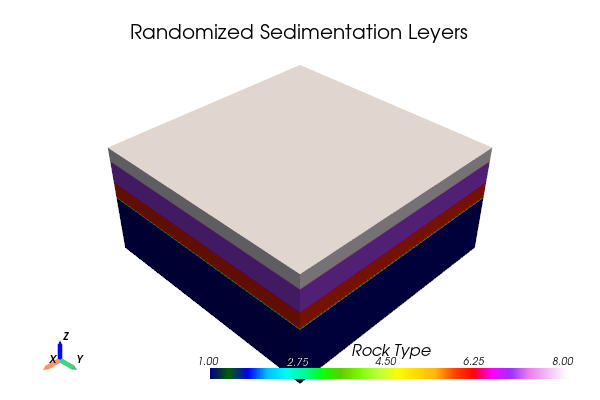

In [5]:
# Create a list of values that represent different types of sedimentary rocks.
sediment_rock_types = list(range(6,9))
average_thickness = 2
variation = np.random.normal(loc = 0, scale=.5, size=len(sediment_rock_types))
thickness_list = average_thickness + variation

# Alternately use the sedimentbuilder
                               
sediment1 = geo.Sedimentation(value_list=sediment_rock_types, thickness_list=thickness_list)
model.clear_history()
model.add_history(bedrock)
model.add_history(sediment1)
model.compute_model()
p3 = geovis.volview(model)
p3.window_size = window_size
p3.add_title(title='Randomized Sedimentation Leyers', font_size=8)
p3.show()

To help with quickly generating sedimentation layers the helper class `SedimentBuilder` is provided. This class has a method `build_layers` which will generate a list of values and thicknesses based on the number of layers and the range of values and thicknesses passed. This can be used to quickly generate a list of values and thicknesses to pass to the sedimentation process.

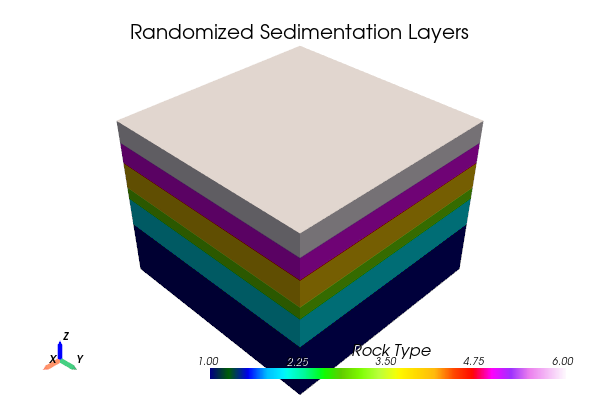

In [6]:
sb = geo.SedimentBuilder(start_value=2,
                         total_thickness=10,
                         min_layers=3,
                         max_layers=6,
                         std = .5)

sediment2 = geo.Sedimentation(*sb.get_layers())
model.clear_history()
model.add_history(bedrock)
model.add_history(sediment2)
model.compute_model()
p3 = geovis.volview(model)
p3.window_size = window_size
p3.add_title(title='Randomized Sedimentation Layers', font_size=8)
p3.show()

### Dikes
A Dike is a planar intrusion of other rocktype into the model. Due to gravity, we expect dikes to fill in a fissure in the rock without extending into the air. This can be accomplished by specifying that the dike replaces existing rock only.

The strike angle is clockwise from north using the local coordinates origin specified by the origin parameter. The dip angle is how steep the dike is from the horizontal plane. The width is the thickness of the dike. The value is the rocktype


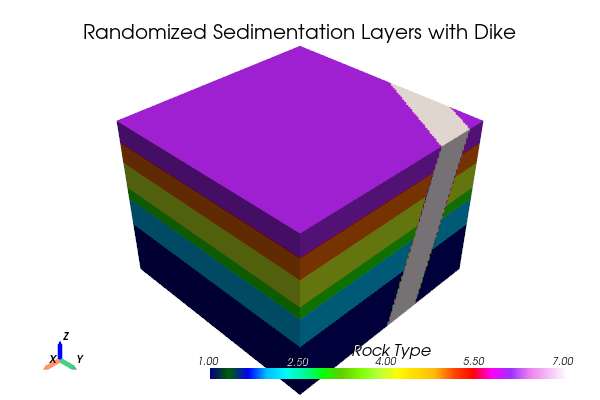

In [7]:
next_value = sediment2.value_list[-1] + 1
dike  = geo.Dike(strike=30, dip=75, width=3, origin=(-6, 8, 0), value=next_value)

history = [bedrock, sediment2, dike]
model.clear_history()
model.add_history(history)
model.compute_model()
p = geovis.volview(model)
p.window_size = window_size
p.add_title(title='Randomized Sedimentation Layers with Dike', font_size=8)
p.show()

### Tilt
Tilt is a simple transformation that tilts the model using the standard strike, dip, and origin prarameters. This specifies the plane of rotation for the tilt. 

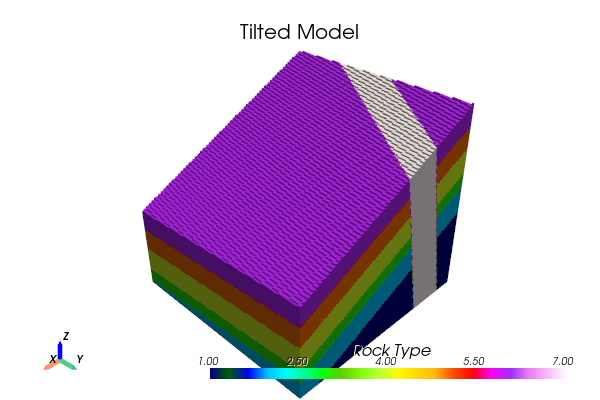

In [8]:
# Tilting axis laid down at edge of model (20) and tilted 15 degrees
tilt = geo.Tilt(strike=10, dip=25, origin=(0, 20, 0))
history = [bedrock, sediment2, dike, tilt]
model.clear_history()
model.add_history(history)
model.compute_model()
p = geovis.volview(model)
p.window_size = window_size
p.add_title(title='Tilted Model', font_size=8)
p.show()

### Deposition ontop of a model
The model lost some of the rock material that makes it interesting from the tilt. We can redeposit sediment on the layers, in the gravity orientation of the the new tilted field. Notice the dike is buried by the new sediment.

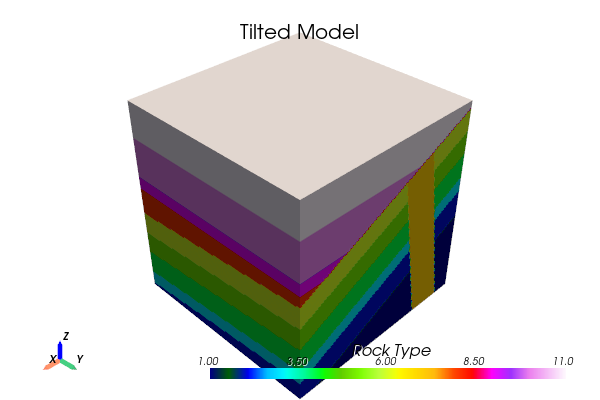

In [9]:
next_value = dike.last_value() + 1
sb = geo.SedimentBuilder(start_value=next_value,
                         total_thickness=12,
                         min_layers=3,
                         max_layers=6,
                         std = .5)

sediment3 = geo.Sedimentation(*sb.get_layers())
history = [bedrock, sediment2, dike, tilt, sediment3]
model.clear_history()
model.add_history(history)
model.compute_model()
p = geovis.volview(model)
p.window_size = window_size
p.add_title(title='Tilted Model', font_size=8)
p.show()

### Folding
Folding is one of the more complex transformations. The plane is defined by strike and dip and the fold direction/polarization is further defined by rake. It can be viewed as a wave with a direction normal to the plane and a polarization given by rake.

The default behaviour has a sinusiod with period and a shape parameter that can further alter the shape overall with a harmonic sinusoid. The tuning parameters for the wave form are period, amplitude, shape, and phase is set by origin.

Optionally a user defined function that accepts an array of n_cycles (number of periods from the strike plane) and returns an array of displacements can be passed. This replaces the default sinusoidal wave form.

#### Strike, Dip, Rake
The two angles form the plane of the plane-wave. The polarization vector of the wave is defined by the rake angle 0 is wave motion up and down, 90 is wave motion left to right. A demonstration of the polarization effect is shown below. Note that strike 90 is East-West and so the wave travels North-South.

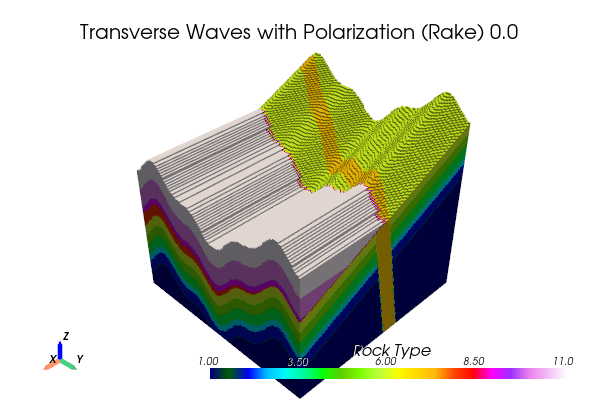

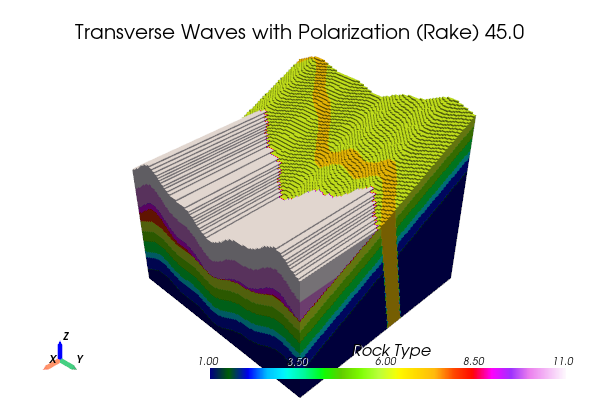

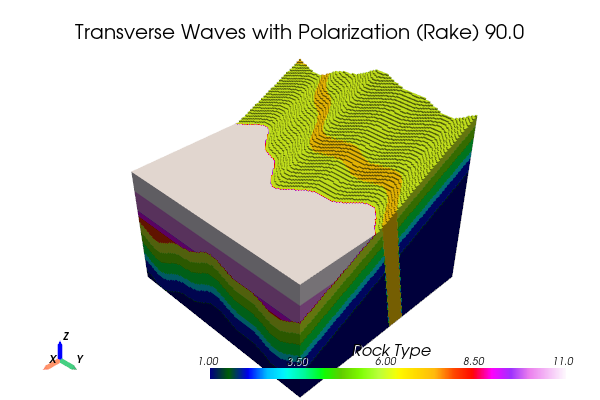

In [10]:
# Define the number of steps (including the end points)
num_steps = 3
# Generate rake values from 0 to 90 degrees, inclusively
rake_values = np.linspace(0, 90, num_steps)

for rake in rake_values:
    fold = geo.Fold(strike=90, dip=90, rake=rake, origin=(0, 0, 0), amplitude=4, period=30, shape=.3)
    history = [bedrock, sediment2, dike, tilt, sediment3, fold]
    # make a new larger model
    bounds = ((-20, 20), (-20, 20), (-20, 20))
    model = geo.GeoModel(bounds=bounds, resolution=128)
    model.clear_history()
    model.add_history(history)
    model.compute_model()
    p = geovis.volview(model)
    p.window_size = window_size
    p.add_title(title=f'Transverse Waves with Polarization (Rake) {rake}', font_size=8)
    p.show()


#### Dipping Effect
With 0 dip the folding effect is vertical instead of transverse which is hard to see without vertical layers.

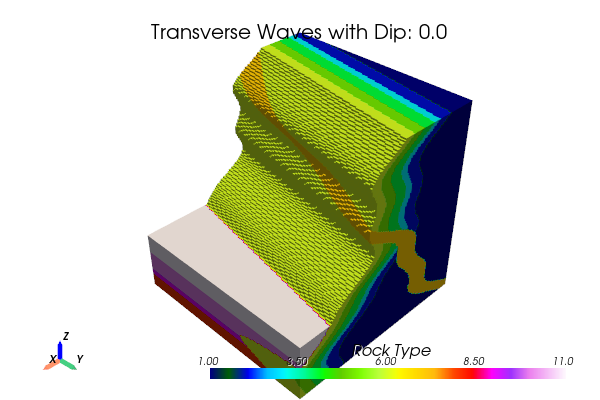

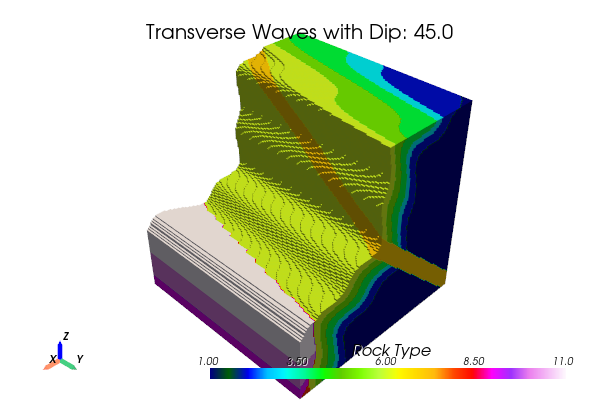

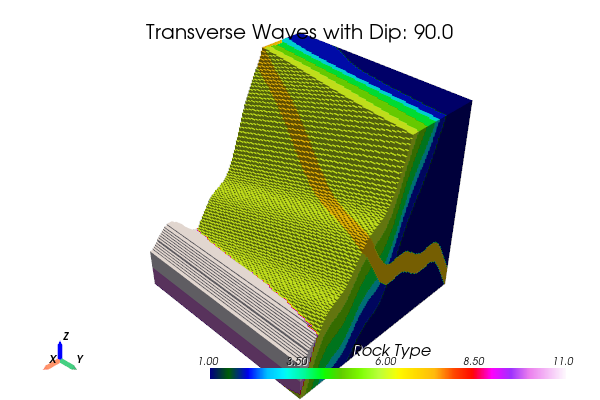

In [11]:
# Define the number of steps (including the end points)
num_steps = 3
# Generate rake values from 0 to 90 degrees, inclusively
dip_values = np.linspace(0, 90, num_steps)

for dip in dip_values:
    fold = geo.Fold(strike=0, dip=dip, rake=0, origin=(0, 0, 0), amplitude=4, period=30, shape=.3)
    tilt = geo.Tilt(strike=10, dip=25, origin=(0, 20, 0))
    tilt2 = geo.Tilt(strike=10, dip=60, origin=(0, 5, 0))
    history = [bedrock, sediment2, dike, tilt2, sediment3, fold]
    # make a new larger model
    bounds = ((-20, 20), (-20, 20), (-20, 20))
    model = geo.GeoModel(bounds=bounds, resolution=128)
    model.clear_history()
    model.add_history(history)
    model.compute_model()
    p = geovis.volview(model)
    p.window_size = window_size
    p.add_title(title=f'Transverse Waves with Dip: {dip}', font_size=8)
    p.show()

#### Custom Waveform
A custom waveform can be passed to the fold process. This is a function that accepts an array of n_cycles (number of periods from the strike plane) and returns an array of displacements. This can be used to create more complex folding patterns.

The wave form is still controlled by the amplitude, period, phase arguments, the waveform does not need to be periodic, but one period or cycle maps to a value of 1.0 in the waveform function.

The probability module has some wave function generators that can be used to create custom waveforms, such as a noisy sinusoid.

The fourier series wave is an interesting option. The wave is built with a specified number of harmonics and a smoothness that is controlled by how quickly the harmonics amplitudes decay. The wave is normalized to have the same RMS as a single sin wave. In this way the amplitude and period map to the same values as the sin wave.

One could also pass in a function such as x^2 to create a parabolic fold.

In [12]:
from structgeo.probability.random import noisy_sine_wave, fourier_series_wave

parabola = lambda x: -(5*x)**2
periodic_funcs = [None, noisy_sine_wave(1, 20, 0.3), fourier_series_wave(num_harmonics=10), parabola]

for fun in periodic_funcs:
    # Period and amplitude modulate the passed function
    fold2 = geo.Fold(strike=110, dip=90, rake=10, origin=(0, 0, 0), amplitude=2, period=30, periodic_func=fun)
    history = [bedrock, sediment2, dike, tilt, sediment3, fold2]
    # make a new larger model
    bounds = ((-20, 20), (-20, 20), (-20, 20))
    model = geo.GeoModel(bounds=bounds, resolution=128)
    model.clear_history()
    model.add_history(history)
    model.compute_model()
    p = geovis.volview(model)
    p.window_size = window_size
    p.add_title(title=f'Fold Model with Wave Function:{fold2.periodic_func.__name__}', font_size=8)
    p.show()

ImportError: cannot import name 'fourier_series_wave' from 'structgeo.probability.random' (c:\users\sghys\2024 summer work\testclone\structuralgeo\src\structgeo\probability\random.py)

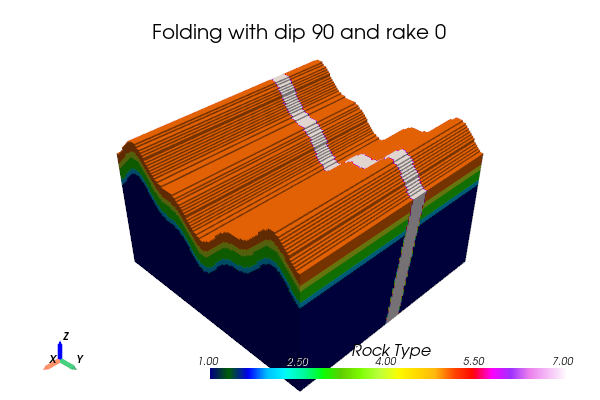

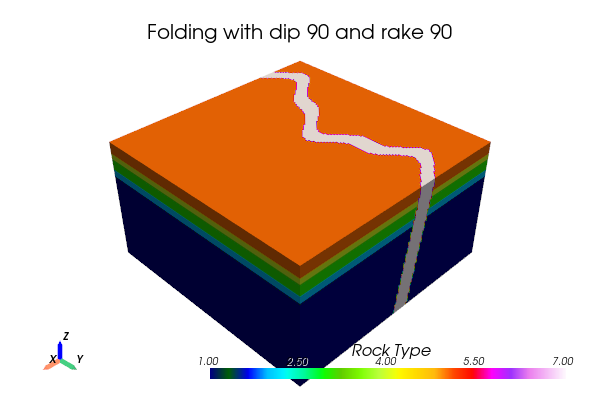

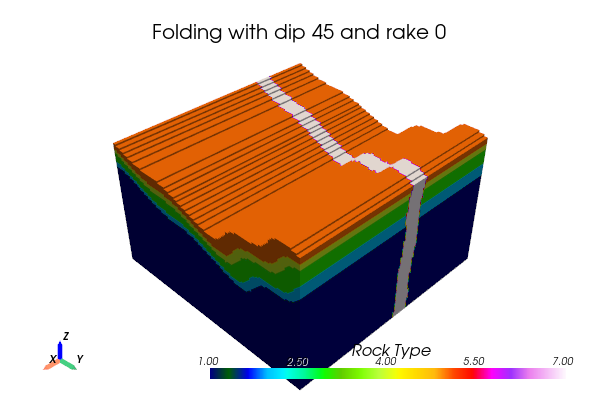

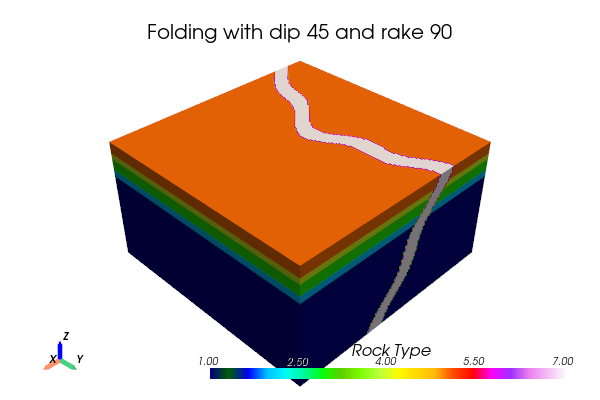

In [ ]:

# Strike controls wave propogation compass direction
# Dip controls wave propogation angle from vertical
# Rake 90 = lateral polarization, Rake 0 = vertical polarization
strike_dip_rake = [(90, 90, 0), (90, 90, 90), (90, 45, 0), (90, 45, 90)]

for params in strike_dip_rake:    
    dike  = geo.Dike(strike=10, dip=80, width=3, origin=(-6, 8, 0), value=7)
    # Make a wave traveling North (y-direction) with lateral polarizaiton (rake 90)
    fold = geo.Fold(*params, origin=(0, 0, 0), amplitude=4, period=30, shape=.3)
    history = [bedrock, sediment0, dike, fold]

    model.clear_history()
    model.add_history(history)
    model.compute_model()
    p = geovis.volview(model)
    p.window_size = window_size
    p.add_title(title=f'Folding with dip {params[1]} and rake {params[2]}', font_size=8)
    p.show(jupyter_backend='static')

### Slips
Slips are a generalized type of transform that involves two layers slipping in either direction. This can be a brittle fracture such as found in a fault, or it can be a shear from in a ductile zone.

Slips are modeled as a function of displacement in the direction of the slip vector, a direction that is parallel to the fault plane and determined by the strike and dip and rake of the the feature.

#### Faults

For Faults the displacement is abrupt, modeled as a step function with a displacement vector. Shear is a plastic deformation modeled using a sigmoid function for a continuous deformation, with steepness controlled by the steepness parameter.

The rake is measured from the strike vector by convention, so unlike folds, lateral motion is given by a rake of 0 or 180 degrees.


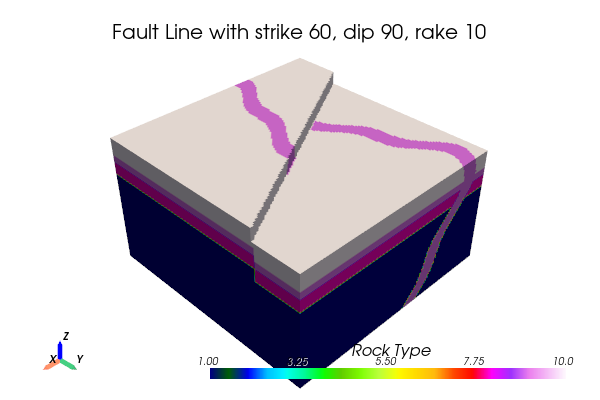

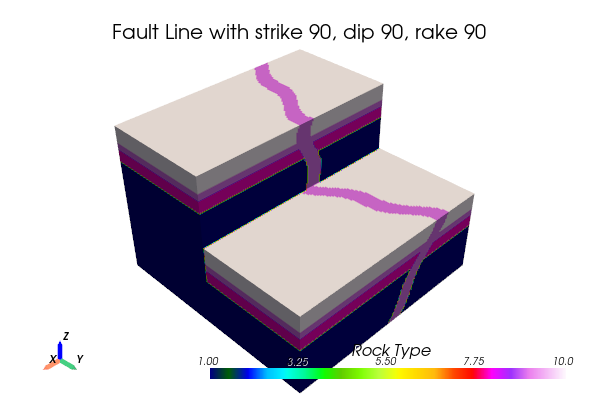

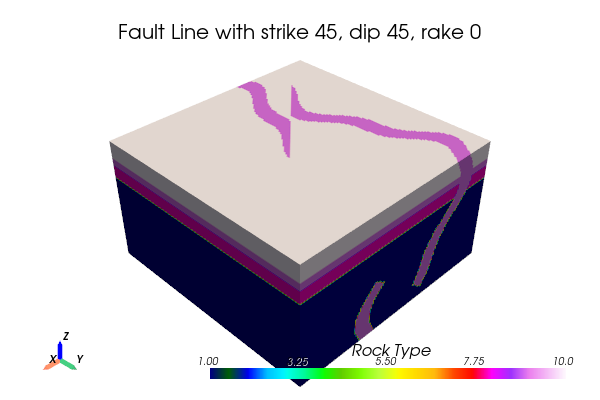

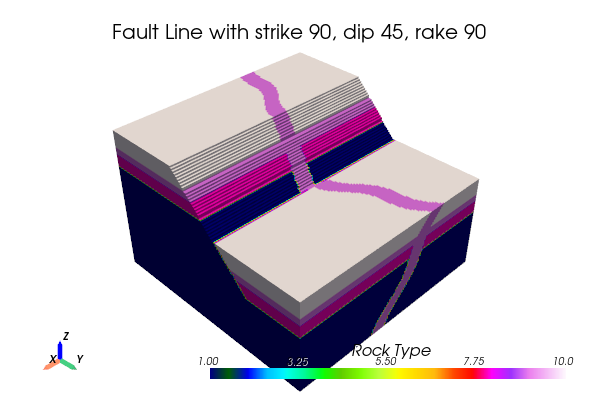

In [ ]:
strike_dip_rake = [(60, 90, 10), (90, 90, 90), (45, 45, 0), (90, 45, 90)]

for params in strike_dip_rake:    
    fault = geo.Fault(*params , amplitude=2.5, origin=(0, 0, 0))
    dike  = geo.Dike(strike=0, dip=75, width=3, origin=(-6, 8, 0), value=9)
    history = [bedrock, sediment3, dike, fold, fault]
    # make a new larger model
    bounds = ((-20, 20), (-20, 20), (-20, 20))
    model = geo.GeoModel(bounds=bounds, resolution=128)
    model.clear_history()
    model.add_history(history)
    model.compute_model()
    p = geovis.volview(model)
    p.window_size = window_size
    p.add_title(title=f'Fault Line with strike {params[0]}, dip {params[1]}, rake {params[2]}', font_size=8)
    p.show()

#### Shear
Shear is a continuous deformation modeled using a sigmoid function for a continuous deformation, with steepness controlled by the steepness parameter.

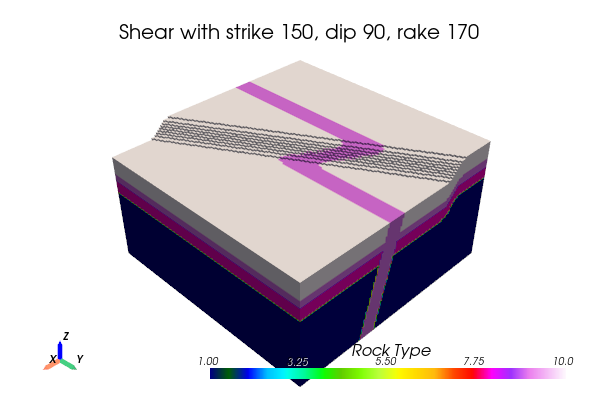

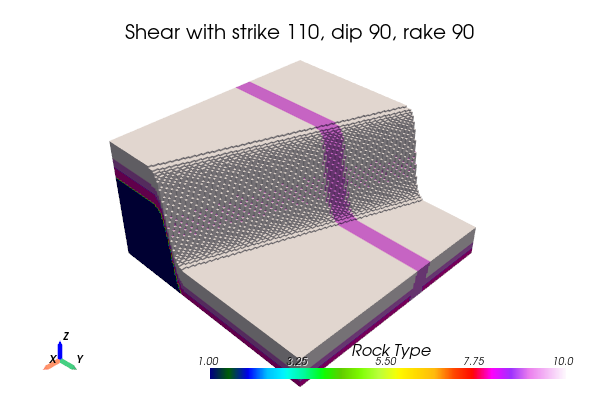

In [ ]:
strike_dip_rake = [(150, 90, 170), (110, 90, 90)]

for params in strike_dip_rake:    
    fault = geo.Shear(*params , amplitude=4, origin=(0, 0, 0), steepness=2)
    dike  = geo.Dike(strike=0, dip=75, width=3, origin=(-6, 8, 0), value=9)
    history = [bedrock, sediment3, dike, fault]
    # make a new larger model
    bounds = ((-20, 20), (-20, 20), (-20, 20))
    model = geo.GeoModel(bounds=bounds, resolution=128)
    model.clear_history()
    model.add_history(history)
    model.compute_model()
    p = geovis.volview(model)
    p.window_size = window_size
    p.add_title(title=f'Shear with strike {params[0]}, dip {params[1]}, rake {params[2]}', font_size=8)
    p.show()

### Additional Custom Slips
A custom slip can be made with a Slip GeoProcess. This is a function that accepts an array of n_cycles (number of periods from the strike plane) and returns an array of displacements.

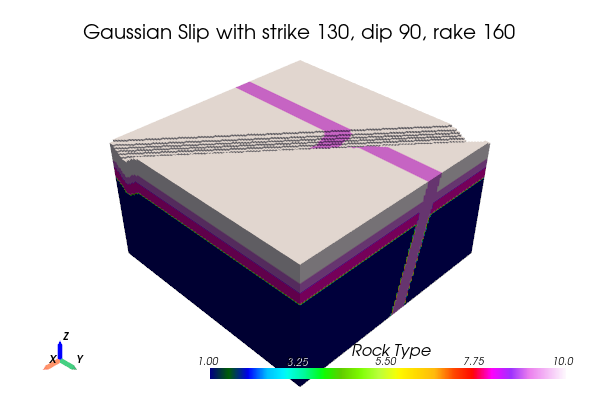

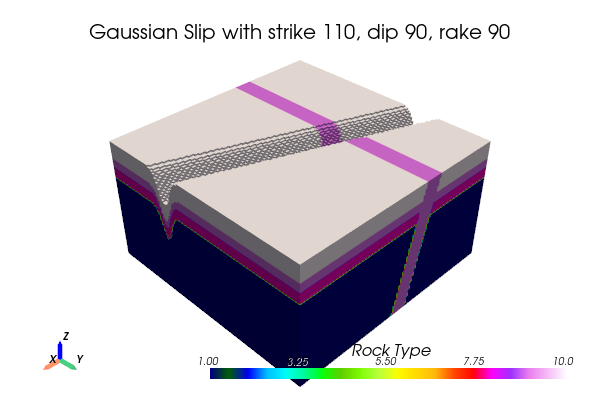

In [ ]:
strike_dip_rake = [(130, 90, 160), (110, 90, 90)]

def gaussian_slip(distances, sigma=1.0):
    def custom_function(distances):   
        return np.exp(-0.5 * (distances / sigma) ** 2)   
    return custom_function  

fun = gaussian_slip(1.0)

for params in strike_dip_rake:    
    fault = geo.Slip(fun, *params , amplitude=5, origin=(0, 0, 0))
    dike  = geo.Dike(strike=0, dip=75, width=3, origin=(-6, 8, 0), value=9)
    history = [bedrock, sediment3, dike, fault]
    # make a new larger model
    bounds = ((-20, 20), (-20, 20), (-20, 20))
    model = geo.GeoModel(bounds=bounds, resolution=128)
    model.clear_history()
    model.add_history(history)
    model.compute_model()
    p = geovis.volview(model)
    p.window_size = window_size
    p.add_title(title=f'Gaussian Slip with strike {params[0]}, dip {params[1]}, rake {params[2]}', font_size=8)
    p.show()